In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

In [7]:
class BondExpansionEstimator(nn.Module):
    def __init__(self, input_size, hidden_layers, check_weights = True):
        super(BondExpansionEstimator, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.check_weights = check_weights
        self.hidden1 = nn.Linear(input_size, hidden_layers[0])
        self.hidden2 = nn.Linear(input_size, hidden_layers[1])
        self.hidden3 = nn.Linear(hidden_layers[0], 1)

    def forward(self, x):
        # Select data related to individual bonds
        # Data- 2D   seq x feat
        seq_len = x.shape[0]
        bond_data = x[:, 0:-1]
        bond_data = bond_data.view(-1, self.input_size)
        # Assume last column of data is bond weight (fraction of volume)
        vol_fracs = x[:, -1]
        # Check the bond weights are well normalized
        if self.check_weights:
            assert torch.abs(torch.sum(vol_fracs) - 1) < 1e-5 
        
        # Run all hidden layers
        out = torch.tanh(self.hidden1(bond_data))
        out = torch.tanh(self.hidden2(bond_data))
        out = torch.tanh(self.hidden3(out))
        out = out.view(-1, seq_len)
        # Sum all bonds according to their bond fractions
        summed = torch.sum(out*vol_fracs)
        return summed

class LatticeDistortionEstimator(nn.Module):
    def __init__(self, input_size):
        super(LatticeDistortionEstimator, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Linear(input_size, 1)

    def forward(self, x):
        # Run all hidden layers
        out = self.layer1(x)

        return out

class CombinedModel(nn.Module):
    def __init__(self, model_a, model_b):
        super(CombinedModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b

    def forward(self, x1, x2):
        output_a = self.model_a(x1)
        output_b = self.model_b(x2)

        return output_a*output_b


## Test Use of Model with Fake Data

In [134]:
# Model Parameters
bond_input_size = 48
distortion_input_size = 4
hidden_layers = [20, 20]

# Training Parameters
learning_rate = 0.0001
num_epochs = 50

# Create an instance of the AdditiveSequentialModel
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers, check_weights=False)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tec_model.parameters(), lr=learning_rate)  # That's me!!
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Generate random sequential data for training
data_size = 1500
seq_length = 5
test_bond_fracs = 0.3*torch.rand(data_size, seq_length, 1)
input_data1 = torch.rand(data_size, seq_length, bond_input_size)
input_data2 = torch.rand(data_size, distortion_input_size)+1
target_data =  2*torch.randn(data_size, 1)  # Start with noise
hidden_A = torch.rand(bond_input_size, 1) # Hidden model
hidden_B = torch.rand(distortion_input_size, 1) # Hidden model
perfect_lab = torch.ones(data_size, 1)  # Start with noise
for i in range(len(target_data)):
    target_data[i] = target_data[i] + torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
    perfect_lab[i] = torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
input_data1 = torch.cat((input_data1, test_bond_fracs), dim=2)

# Training loop
loss_log = []
for epoch in range(num_epochs):
    # Forward pass
    losses = []
    for in1, in2, y in zip(input_data1, input_data2, target_data):
        outputs = tec_model(in1, in2)
        loss = criterion(outputs, y)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example of using the trained model for prediction
test_input1 = torch.randn(1, seq_length, bond_input_size+1)
test_input2 = torch.randn(1, distortion_input_size)
predicted_output = torch.zeros(data_size, 1)
for i in range(data_size):
    predicted_output[i] = tec_model(input_data1[i], input_data2[i])

Number of parameters:  1986
Epoch [10/50], Loss: 344.7103
Epoch [20/50], Loss: 135.8409
Epoch [30/50], Loss: 25.7103
Epoch [40/50], Loss: 0.0150
Epoch [50/50], Loss: 3.4444


Input1 shape: torch.Size([1, 5, 49])
Input2 shape: torch.Size([1, 4])


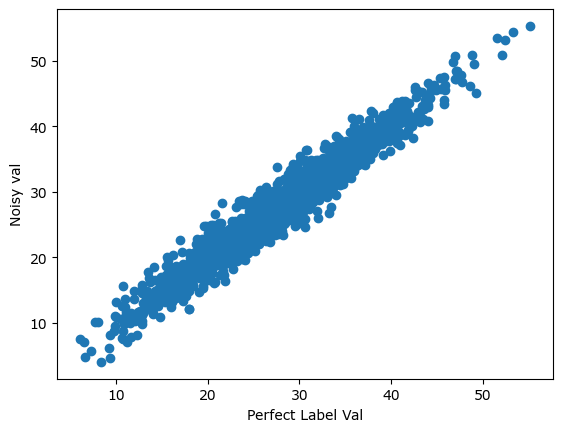

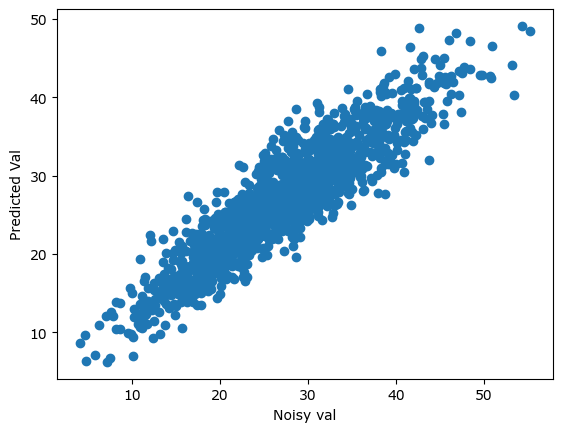

In [135]:
# Results
print("Input1 shape:", test_input1.shape)
print("Input2 shape:", test_input2.shape)

plt.scatter(perfect_lab.numpy(), target_data.numpy())
plt.ylabel("Noisy val")
plt.xlabel("Perfect Label Val")
plt.show()

plt.scatter(target_data.numpy(), predicted_output.detach().numpy())
plt.xlabel("Noisy val")
plt.ylabel("Predicted Val")
plt.show()


## Now Train on Real Data with SGD

## Load in Data

In [4]:
labels_df = pd.read_csv("labels/labels_reduced.csv", index_col=0)
features_df = pd.read_csv("features/features.csv")

# Choose Features
columns_all = features_df.columns[3:-1].to_list()  # ALL FEATURES, exclude file names and bond volume fractions
feature_weights = features_df[features_df.columns[-1]].to_numpy()

# Copy over labels to each bond (just for correlation)
y = list()
combined_data = list()
weights = list()
labels_skipped = 0
max_length = 0
all_phases = set()
for idx in labels_df.index:
    phase = labels_df.loc[idx, 'phase_id']
    feat = features_df[features_df['structure_name'] == str(int(phase))+'_super.cif']  # Select all rows applicable to 
    if len(feat) > 0:
        weights.append(torch.Tensor(feat['volume_fraction'].values).to(torch.float).view(len(feat),1))
        feat = feat[columns_all]
        feat['temperature'] = labels_df.loc[idx, "temperature"]  # add temperature as a feature
        max_length = max(max_length, len(feat))
        combined_data.append(torch.Tensor(feat.values).to(torch.float))
        y.append( labels_df.loc[idx, "thermal_expansion"] )
        all_phases.add(phase)
    else:
        print("Phases ", phase, " not found in structures")
        labels_skipped += 1

print("Total Number of Labels: ", len(y))
print("Skipped {} structures".format(labels_skipped))
print("Total Unique structures", len(all_phases))
# Recast y as a torch tensor
y = torch.Tensor(y)
y = y.view(-1,1)

Phases  13996.0  not found in structures
Phases  131156.0  not found in structures
Phases  130566.0  not found in structures
Phases  71777.0  not found in structures
Phases  71777.0  not found in structures
Phases  71776.0  not found in structures
Phases  71776.0  not found in structures
Phases  142888.0  not found in structures
Phases  127780.0  not found in structures
Phases  122321.0  not found in structures
Phases  59916.0  not found in structures
Phases  9782.0  not found in structures
Phases  12354.0  not found in structures
Phases  70111.0  not found in structures
Phases  70110.0  not found in structures
Phases  70180.0  not found in structures
Phases  70109.0  not found in structures
Phases  70109.0  not found in structures
Phases  77642.0  not found in structures
Phases  128280.0  not found in structures
Phases  70179.0  not found in structures
Phases  15966.0  not found in structures
Phases  15933.0  not found in structures
Phases  120633.0  not found in structures
Phases  12

In [70]:
# Make sure all weights are normalized
# TODO: figure out why this is necessary
for i in range(len(weights)):
    s = torch.sum(weights[i])
    if abs(s-1) > 1e-6:
        weights[i] = weights[i]/s

In [71]:
# Build and Normalize X
X_mean = torch.mean(torch.cat(combined_data),dim=0)
X_std = torch.std(torch.cat(combined_data),dim=0)
X = []
for x,w in zip(combined_data, weights):
    X.append(torch.cat(((x-X_mean)/X_std, w), dim=1))

In [72]:
# Normalize Y
y_mean = torch.mean(y)
y_std = torch.std(y)
y = (y-y_mean)/y_std

In [73]:
y_std

tensor(9.5599)

In [74]:
y_mean

tensor(10.7358)

In [75]:
# Save tensors to a file
torch.save({'X': X, 'y': y, 'X_mean':X_mean, 'X_std':X_std, 'y_mean':y_mean, 'y_std':y_std}, 'features/data_tensors.pth')

## Create and Train Model

In [12]:
# Load tensors from the file
loaded_data = torch.load('features/data_tensors.pth')
X = loaded_data['X']
y = loaded_data['y']
X_mean = loaded_data['X_mean']
X_std = loaded_data['X_std']
y_mean = loaded_data['y_mean']
y_std = loaded_data['y_std']
print("Number labels:", len(y))

Number labels: 1081


In [13]:
# Model Parameters
bond_input_size = len(X[0][0])-1  # Don't count bond length weights
distortion_input_size = 2
hidden_layers = [30, 30]

# Training Parameters
learning_rate = 0.001
num_epochs = 20000
batch_size = 1  # True SGD due to data being varying length sequences

# Set up Cross Validation with K-Folds
n_splits = 10
fold_num = 0  # Tracking current fold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_metrics = []

# Structure Descriptions: Fit single parameter for now on ones
# TODO: Add actual features for structure
X_struc = torch.ones(len(X), distortion_input_size)


# Check GPU Availability
if torch.cuda.is_available():
    print("Available GPU Device:", torch.cuda.get_device_name(0))
else: 
    print("GPU not available, using CPU...")


Available GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU


## Perform k-fold cross-validation

In [14]:
loss_log = list()
for train_index, test_index in kf.split(X):
    train_index = list(train_index)
    test_index = list(test_index)
    fold_num += 1
    
    # Create an instance of the model
    expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
    distortion_model = LatticeDistortionEstimator(distortion_input_size)
    tec_model = CombinedModel(expansion_model, distortion_model)
    
    # Define a loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(expansion_model.parameters(), lr=learning_rate)  # That's me!!
    
    # Train on GPU
    if torch.cuda.is_available():
        tec_model = tec_model.to('cuda') 
    
    print("Starting K Fold {} out of {}".format(fold_num, n_splits))
    # Training loop
    losses = list()
    for epoch in range(num_epochs):
        # Sample one data point for SGD
        train_idx = random.choice(train_index)
        
        # Move training to GPU if available
        if torch.cuda.is_available():
            batch_X, batch_X_struc, batch_y = X[train_idx].to('cuda'), X_struc[train_idx].to('cuda'), y[train_idx].to('cuda')
        else:
            batch_X, batch_X_struc, batch_y = X[train_idx], X_struc[train_idx], y[train_idx]

        # Forward pass
        outputs = tec_model(batch_X, batch_X_struc)  
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss to make convergence plots
        losses.append(loss.item())
        
        # Print loss every N epochs
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses[-1000:]):.4f}')
            
    loss_log.append(losses) 
    
    # Evaluate the model on the test set for this fold
    tec_model.eval()
    X_test = [X[i] for i in test_index]
    X_struc_test = [X_struc[i] for i in test_index]
    y_test = torch.cat([y[i] for i in test_index])
    with torch.no_grad():
        y_pred = []
        for x, x_struc in zip(X_test, X_struc_test):
            if torch.cuda.is_available():
                x, x_struc = x.to('cuda'), x_struc.to('cuda')
            y_pred.append(tec_model(x, x_struc).cpu())
        y_pred = torch.cat(y_pred)

    # Compute the evaluation metric for this fold 
    metric1 = mean_squared_error(y_test.numpy(), y_pred.numpy())
    metric2 = mean_absolute_error(y_test.numpy(), y_pred.numpy())
    fold_metrics.append([metric1, metric2])

    # Clear cache on GPU
    torch.cuda.empty_cache()  
 

Starting K Fold 1 out of 10
Epoch [1000/15000], Loss: 0.8640
Epoch [2000/15000], Loss: 0.7418
Epoch [3000/15000], Loss: 0.9905
Epoch [4000/15000], Loss: 1.0247
Epoch [5000/15000], Loss: 0.8429
Epoch [6000/15000], Loss: 0.7667
Epoch [7000/15000], Loss: 0.9018
Epoch [8000/15000], Loss: 0.7760
Epoch [9000/15000], Loss: 1.1490
Epoch [10000/15000], Loss: 1.0330
Epoch [11000/15000], Loss: 0.7596
Epoch [12000/15000], Loss: 0.6977
Epoch [13000/15000], Loss: 0.8438
Epoch [14000/15000], Loss: 0.6836
Epoch [15000/15000], Loss: 0.7411
Starting K Fold 2 out of 10
Epoch [1000/15000], Loss: 0.7944
Epoch [2000/15000], Loss: 0.9261
Epoch [3000/15000], Loss: 0.8503
Epoch [4000/15000], Loss: 0.5454
Epoch [5000/15000], Loss: 1.0880
Epoch [6000/15000], Loss: 0.6502
Epoch [7000/15000], Loss: 0.9669
Epoch [8000/15000], Loss: 0.8852
Epoch [9000/15000], Loss: 0.8381
Epoch [10000/15000], Loss: 0.8229
Epoch [11000/15000], Loss: 0.6523
Epoch [12000/15000], Loss: 1.0369
Epoch [13000/15000], Loss: 1.0110
Epoch [140

In [15]:
# Report Number of Parameters
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Calculate the average performance across all folds
fold_metrics = np.array(fold_metrics)
average_mse = np.mean(fold_metrics[:,0])
average_me = np.mean(fold_metrics[:,1])
print("Average MSE: ", average_mse)
print("Average Absolute Error [10-6/K]: ", average_me*y_std)
print("Variance in Absolute Error [10-6/K]: ", np.var(fold_metrics[:,1])*y_std)

Number of parameters:  3034
Average MSE:  0.885324
Average Absolute Error [10-6/K]:  tensor(5.2995)
Variance in Absolute Error [10-6/K]:  tensor(0.0279)


R2 Score:  0.17666010343455962


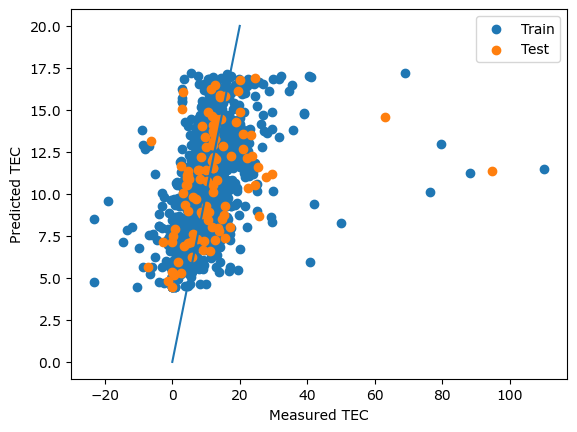

In [19]:
# Prediction for train set
y_train = torch.cat([y[i] for i in train_index])
X_train = [X[i] for i in train_index]
X_struc_train = [X_struc[i] for i in train_index]
y_pred_train = []
for x, x_struc in zip(X_train, X_struc_train):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_train.append(tec_model(x, x_struc).cpu())
y_pred_train = torch.cat(y_pred_train)


# Transform back
y_measure_train = (y_train*y_std)+y_mean
y_measure_test = (y_test*y_std)+y_mean
y_predict = (y_pred*y_std)+y_mean
y_pred_train = (y_pred_train*y_std)+y_mean

print("R2 Score: ", r2_score(y_measure_train.numpy(), y_pred_train.detach().numpy()))

# Plot data
plt.scatter(y_measure_train.numpy(), y_pred_train.detach().numpy())
plt.scatter(y_measure_test.numpy(), y_predict.detach().numpy())
plt.legend(["Train", "Test"])
plt.xlabel("Measured TEC")
plt.ylabel("Predicted TEC")
plt.plot([-0, 20], [0, 20])
plt.show()

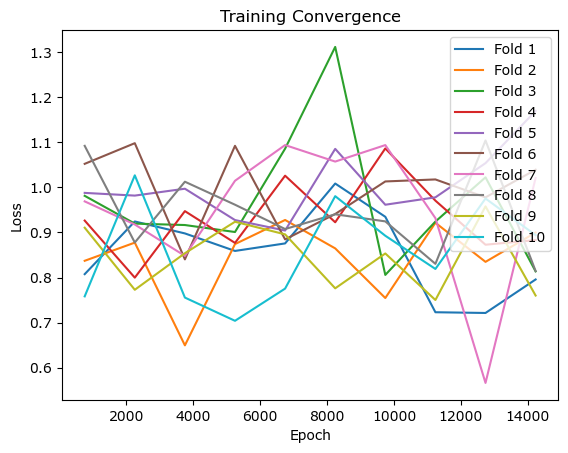

In [20]:
# Graph the Loss after each set of Batches 
k_smooth = 10
loss_log = np.array(loss_log)
smoothed_loss = []
avg_epoch = []
n_smooth = int(max(loss_log.shape)/k_smooth) - 1
for i in range(k_smooth):
    smoothed_loss.append(np.mean(loss_log[:, i*n_smooth:(i+1)*n_smooth], axis=1))
    avg_epoch.append((i+0.5)*n_smooth)
smoothed_loss = np.array(smoothed_loss)

plt.plot(avg_epoch, smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend(['Fold {}'.format(i) for i in range(1,n_splits+1)])
plt.show()

## Train on whole Data set (for model testing)

In [10]:
learning_rate = 0.001
num_epochs = 20000

loss_log = list()

# Create an instance of the model
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(expansion_model.parameters(), lr=learning_rate)  # That's me!!

# Train on GPU
if torch.cuda.is_available():
    tec_model = tec_model.to('cuda')

# Training loop
losses = list()
train_index = np.arange(len(X))
for epoch in range(num_epochs):
    # Sample one data point for SGD
    train_idx = random.choice(train_index)

    # Move training to GPU if available
    if torch.cuda.is_available():
        batch_X, batch_X_struc, batch_y = X[train_idx].to('cuda'), X_struc[train_idx].to('cuda'), y[train_idx].to('cuda')
    else:
        batch_X, batch_X_struc, batch_y = X[train_idx], X_struc[train_idx], y[train_idx]

    # Forward pass
    outputs = tec_model(batch_X, batch_X_struc)
    loss = criterion(outputs, batch_y)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record loss to make convergence plots
    losses.append(loss.item())

    # Print loss every N epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses[-1000:]):.4f}')

loss_log.append(losses)
# Clear cache on GPU
torch.cuda.empty_cache()


Epoch [1000/20000], Loss: 0.8489
Epoch [2000/20000], Loss: 1.0505
Epoch [3000/20000], Loss: 1.1413
Epoch [4000/20000], Loss: 0.6032
Epoch [5000/20000], Loss: 0.8975
Epoch [6000/20000], Loss: 0.6989
Epoch [7000/20000], Loss: 1.0755
Epoch [8000/20000], Loss: 0.7094
Epoch [9000/20000], Loss: 1.1118
Epoch [10000/20000], Loss: 0.7743
Epoch [11000/20000], Loss: 0.7559
Epoch [12000/20000], Loss: 1.0221
Epoch [13000/20000], Loss: 0.9977
Epoch [14000/20000], Loss: 0.5150
Epoch [15000/20000], Loss: 0.7886
Epoch [16000/20000], Loss: 0.8547
Epoch [17000/20000], Loss: 0.8639
Epoch [18000/20000], Loss: 0.8293
Epoch [19000/20000], Loss: 0.9496
Epoch [20000/20000], Loss: 1.0214


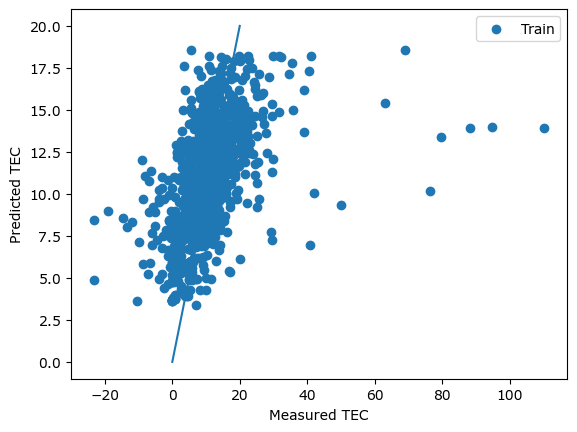

R2 Score:  0.20817006474598465


In [11]:
# Prediction for train set
y_train = torch.cat([y[i] for i in train_index])
X_train = [X[i] for i in train_index]
X_struc_train = [X_struc[i] for i in train_index]
y_pred_train = []
for x, x_struc in zip(X_train, X_struc_train):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_train.append(tec_model(x, x_struc).cpu())
y_pred_train = torch.cat(y_pred_train)

# Transform back
y_measure_train = (y_train*y_std)+y_mean
y_pred_train = (y_pred_train*y_std)+y_mean

# Plot data
plt.scatter(y_measure_train.numpy(), y_pred_train.detach().numpy())
plt.legend(["Train", "Test"])
plt.xlabel("Measured TEC")
plt.ylabel("Predicted TEC")
plt.plot([0, 20], [0, 20])
plt.show()

print("R2 Score: ", r2_score(y_measure_train.numpy(), y_pred_train.detach().numpy()))